# 제목: Feature selection 알고리즘인 Boruta algorithm에 대한 설명

출처: [https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

# 가장 효과적인 기능 선택 알고리즘 중 하나인 Boruta의 내부 살펴보기

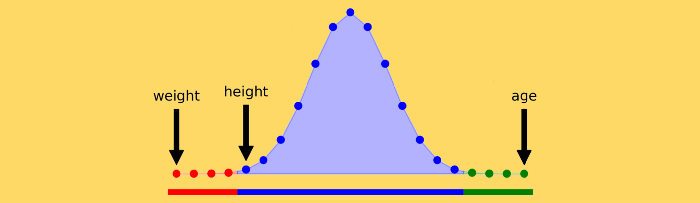

Feature selection은 많은 machine learning pipeline에서 기본적인 단계입니다. feature selection의 목적은 불필요한 noise를 유발하는 불필요한 features를 제거하여 문제를 단순화하는 것입니다.

Boruta는 2010년부터 데이터 세트에서 feature selection을 자동으로 수행하도록 설계된 매우 스마트한 알고리즘입니다.

이 포스트에서, 우리는 밑바닥부터 Boruta를 구현하기 위한 몇 가지 간단한 Python 코드를 볼 것입니다. 무언가를 밑바닥부터 구현하는 것은 실제로 어떤 것을 이해하는 가장 좋은 방법이라고 믿습니다. 그리고 포스트의 끝에서 우리는 BorutaPy를 사용합니다.

# 1. It all starts with X and y
Boruta가 작동하는 모습을 보기 위해 3가지 features (age, height 및 weight), target variable (income) 및 5개의 observations가 있는 toy dataset를 구축해 보겠습니다.

In [1]:
import pandas as pd

X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                  'height': [182, 176, 174, 168, 181],
                  'weight': [75, 71, 78, 72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name = 'income')

In [2]:
X

,age,height,weight
0,25,182,75
1,32,176,71
2,47,174,78
3,51,168,72
4,62,181,86


In [3]:
pd.DataFrame(y)

,income
0,20
1,32
2,45
3,55
4,61


따라서, 목표는 나이, 키 및 체중을 알고 있는 사람의 소득을 예측하는 것입니다

실제 상황에서는 3가지 이상의 features(일반적으로 수백에서 수천 개)를 처리해야 합니다. 따라서, features를 일일이 검토하고 유지할 것인지 말 것인지를 결정하는 것은 실현 불가능한 일일 것입니다. 더욱이, 정확한 분석으로도 인간의 눈에 쉽게 포착되지 않는 관계(비선형 관계나 상호작용 등)가 존재합니다.

따라서, X의 주어진 features가 y에 대한 예측 값과 관계가 있는지 여부를 자동으로 결정할 수 있는 알고리즘을 찾고 싶습니다.

# 2. Why Boruta?
Feature selection을 위한 인기 있는 알고리즘은 sklearn의 SelectFromModel입니다. 기본적으로 비선형 관계 및 상호 작용을 담아낼 수 있는 편리한 모델(예를 들어, RandomForest)을 선택합니다. 그리고 X와 y에 모델을 학습시킵니다. 그런 다음, 이 모델에서 각 feature importances를 추출하고 주어진 importance의 threshold보다 높은 features만 유지합니다.

위의 방법은 합리적으로 보이지만, 이러한 접근 방식은 약점이 있습니다. 누가 threshold를 어떻게 결정합니까? 그 안에는 많은 자의성이 있습니다.

Boruta는 통계적으로 기반을 둔 feature selection 알고리즘이며 사용자의 특정 input 없이도 매우 잘 작동합니다.

Boruta는 두 가지 아이디어를 기반으로 합니다.

## 2.1 The first idea: shadow features
**Boruta에서 features는 서로 경쟁하지 않습니다. 대신, features는 무작위 버전과 경쟁합니다.**

실제로, 각 features를 무작위로 섞어서 다른 데이터 프레임을 생성합니다. 이러한 재배치된 features를 **shadow features**라고 합니다. 이 시점에서, shadow 데이터 프레임은 원래 데이터 프레임에 연결되어 X의 칼럼 수에 두 배인 새 데이터 프레임(X_boruta)을 얻습니다.

In [4]:
import numpy as np

np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ["shadow_" + feat for feat in X.columns]

X_boruta = pd.concat([X, X_shadow], axis=1)

X_boruta

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,47,182,78
1,32,176,71,32,174,72
2,47,174,78,62,181,71
3,51,168,72,25,168,86
4,62,181,86,51,176,75


그런 다음, RandomForest로 X_boruta와 y를 학습합니다.

이제 각각의 original feature importances를 가져와 threshold와 비교합니다. 이때, threshold는 shadow features 중에 기록된 가장 높은 importance로 정의됩니다. feature importance가 이 threshold보다 높을 때 이를 "hit"라고 합니다. 이 아이디어는 feature이 feature importance가 가장 높은 randomized feature보다 더 높은 경우에만 유용하다는 것입니다.

이 프로세스를 재현하는 코드는 다음과 같습니다.

In [5]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=5, random_state=42)
forest.fit(X_boruta, y)

feat_imp_X = forest.feature_importances_[:len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns):]

hits = feat_imp_X > feat_imp_shadow.max()

결과는 다음과 같습니다.

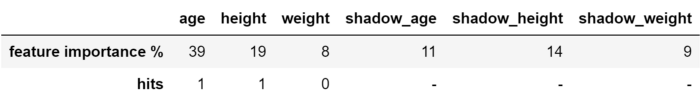

Threshold는 14%이므로 age와 hieght(각각 39% 및 19%)의 2가지 features가 hit한 반면 weight(8%)은 threshold 미만으로 점수가 매겨졌습니다.

명백하게, weight을 버리고 age와 height를 유지해야 합니다. 하지만, 이 실행 결과를 믿어야 할까요? 만약 이것이 단지 운이 없는 run이었다면? 대신 age와 height가 운이 좋은 run이라면 어떨까요?

여기에서 Boruta의 두 번째 기발한 아이디어가 작동합니다.

## 2.2 The second idea: binomial distribution
Machine learning에서 위와 같은 상황은 자주 발생합니다. 따라서, 핵심은 반복입니다. 당연히 20번의 시행은 1번의 시행보다 더 신뢰할 수 있고, 100번의 시행은 20번의 시행보다 더 신뢰할 수 있습니다.

예를 들어, 위에서 본 과정을 20번 반복해봅시다.

In [6]:
hits = np.zeros((len(X.columns)))

for iter_ in range(20):
    np.random.seed(iter_)
    X_shadow = X.apply(np.random.permutation)
    X_boruta = pd.concat([X, X_shadow], axis=1)
    
    forest = RandomForestRegressor(max_depth=5, random_state=42)
    forest.fit(X_boruta, y)
    
    feat_imp_X = forest.feature_importances_[:len(X.columns)]
    feat_imp_shadow = forest.feature_importances_[len(X.columns):]
    
    hits += (feat_imp_X > feat_imp_shadow.max())

다음은 결과입니다.

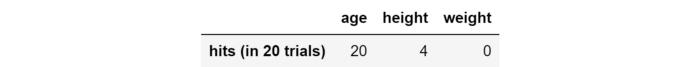


이제 결정하는 기준을 어떻게 설정합까요? 이것이 Boruta에 담긴 두 번째 기발한 아이디어입니다.

feature(age, height 또는 weight에 관계 없이)을 취하고, 그것이 유용한지 아닌지 전혀 모른다고 가정해 보겠습니다. 우리가 feature을 keep할 확률은 얼마일까요? feature에 대한 불확실성의 최대 수준은 동전 던지기와 같은 50%의 확률로 표현됩니다. 각 독립 실험은 binary 결과(hit 또는 no hit)를 제공할 수 있으므로 n trials의 series는 이항 분포를 따릅니다.

Python에서 이항 분포의 확률 질량 함수는 다음과 같이 계산할 수 있습니다:

In [7]:
import scipy as sp
trials = 20
pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(trials + 1)]

이 값들은 종 같이 생겼습니다:

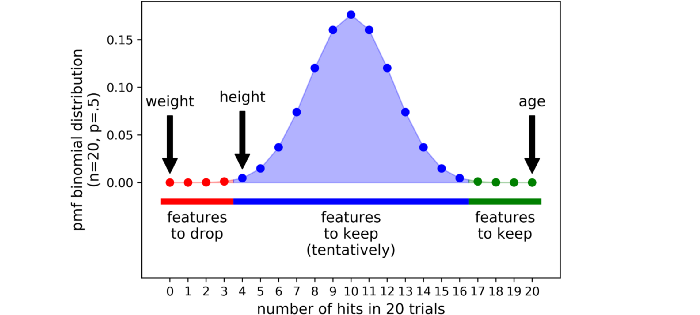


Boruta에서는 refusal과 acceptance 영역 사이에 엄격한 threshold이 없습니다. 대신 3가지 영역이 있습니다:


- **area of refusal** (the red area): 여기서 끝나는 features는 noise로 간주되어 삭제됩니다.


- **area of irresolution** (the blue area): Boruta는 이 영역에 있는 features에 대해 뚜렷한 결과를 내놓지 않습니다.


- **area of acceptance** (the green area): 여기에 있는 features는 예측 가능한 것으로 간주되므로 유지됩니다.


**Tails of the distribution**라고 하는 분포의 가장 극단적인 두 부분을 선택하여 정의됩니다(이 예에서 각 tail은 분포의 0.5%를 차지함).

따라서, 여기서는 toy data에 대해 20번의 반복을 수행했고, 결국 통계적으로 근거한 몇 가지 결론을 얻었습니다:


- 사람의 소득을 예측하기 위해서는 age를 예측하고 keep해야 하며, weight은 noise일 뿐이고 빼야 한다.


- Boruta는 height에 대해 확실한 결론을 내지 않았습니다. 선택은 우리에게 달려 있지만, 보수적인 프레임에서는 유지하는 것이 좋습니다.


이 단락에서는 필요한 코드를 구현했지만, Python에서는 Boruta에 대한 훌륭한 라이브러리가 있습니다.

# 3. Using BorutaPy in Python

In [8]:
# pip install boruta

In [9]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

forest = RandomForestRegressor(n_jobs=-1, max_depth=5)
boruta = BorutaPy(estimator=forest, n_estimators="auto", max_iter=100)
boruta.fit(np.array(X), np.array(y))

green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

# 이 아티클의 이미지와 결과가 다를 수 있습니다.
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: ['age']


# 4. Conclusion
Feature selection은 machine learning pipeline의 결정적인 부분입니다. 너무 보수적이면 불필요한 노이즈를 도입하는 것이고, 너무 공격적이면 유용한 정보를 버리는 것을 의미합니다.

이 포스트에서는 데이터 세트에서 robust하고 통계적으로 근거한 feature selection을 수행하기 위해 Boruta를 사용하는 방법을 보았습니다. 실제로 features에 대한 실질적인 결정을 내리는 것은 예측 모델의 성공을 보장하는데 중요합니다.